# Variational Autoencoder in TensorFlow

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Let us first do the necessary imports, load the data (MNIST), and define some helper functions.

In [2]:
import numpy as np
import tensorflow as tf
import prettytensor as pt
from prettytensor.pretty_tensor_class import DIM_SAME
from deconv import deconv2d
import os
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print n_samples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
55000


Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

In [6]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, params, network_architecture, transfer_fct=tf.nn.softplus):
        self.network_architecture = network_architecture
        self.params = params
        self.transfer_fct = transfer_fct
        self.learning_rate = params['learning_rate']
        self.batch_size = self.params['batch_size']
        self.hidden_size = self.params["n_z"]
        self.train_writer = tf.train.SummaryWriter(params['summary_folder'])
        self.x_size = network_architecture["n_input"]
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, self.x_size])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        self.saver = tf.train.Saver(tf.all_variables())
        
        if not os.path.exists(params['model_folder']):
            os.makedirs(params['model_folder'])
            print("+++ Created snapshot folder path: %s" % params['model_folder'])
    
    def _create_network(self):
        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
#         with tf.variable_scope("model") as scope:
        with pt.defaults_scope(activation_fn=tf.nn.elu,
                               batch_normalize=True,
                               learned_moments_update_rate=0.0003,
                               variance_epsilon=0.001,
                               scale_after_normalization=True):
            hidden_tensor, self.z_mean, self.z_log_sigma_sq = \
                self._recognition_network_conv(self.x)

            # Draw one sample z from Gaussian distribution
            self.eps = tf.random_normal([tf.shape(self.z_mean)[0], self.hidden_size])
            # z = mu + sigma*epsilon
            self.z = self.z_mean + self.eps * self.z_log_sigma_sq
            print self.z
            # Use generator to determine mean of
            # Bernoulli distribution of reconstructed input
            self.x_reconstr_mean = \
                self._generator_network_conv(self.z)
            print self.x_reconstr_mean.get_shape().as_list()
    
    def _recognition_network_conv(self, input_tensor):
        hidden_tensor = (pt.wrap(input_tensor).
            reshape([self.batch_size, 28, 28, 1]).
            conv2d(5, 32, stride=2).
            conv2d(5, 64, stride=2).
            conv2d(5, 128, edges='VALID').
            dropout(0.9).
            flatten().
            fully_connected(self.params['n_z'] * 2, activation_fn=None)).tensor
        z_mean = hidden_tensor[:, :self.params['n_z']]
        z_log_sigma_sq = tf.sqrt(tf.exp(hidden_tensor[:, self.params['n_z']:]))
        return (hidden_tensor, z_mean, z_log_sigma_sq)

    
    def _generator_network_conv(self, input_sample):
        return (pt.wrap(input_sample).
                reshape([self.batch_size, 1, 1, self.hidden_size]).
                deconv2d(3, 128, edges='VALID').
                deconv2d(5, 64, edges='VALID').
                deconv2d(5, 32, stride=2).
                deconv2d(5, 1, stride=2, activation_fn=tf.nn.sigmoid).
                flatten()).tensor
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluatio of log(0.0)
        epsilon = 1e-8
        self.reconstr_loss = tf.reduce_sum(-self.x * tf.log(self.x_reconstr_mean + epsilon) -
                         (1.0 - self.x) * tf.log(1.0 - self.x_reconstr_mean + epsilon))
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        self.latent_loss = tf.reduce_sum(0.5 * (tf.square(self.z_mean) + tf.square(self.z_log_sigma_sq) -
                                2.0 * tf.log(self.z_log_sigma_sq + epsilon) - 1.0))
        self.cost = tf.reduce_mean(self.reconstr_loss + self.latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, epsilon=1.0).minimize(self.cost)
#         self.optimizer = tf.train.AdagradOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        summary_loss = tf.scalar_summary('loss/loss', self.cost / (self.x_size * self.batch_size))
        summary_loss_reconstr = tf.scalar_summary('loss/rec_loss', tf.reduce_mean(self.reconstr_loss) / (self.x_size * self.batch_size))
        summary_loss_latent = tf.scalar_summary('loss/vae_loss', tf.reduce_mean(self.latent_loss) / (self.x_size * self.batch_size))
        summaries = [summary_loss, summary_loss_reconstr, summary_loss_latent]
        global merged_summaries
        merged_summaries = tf.merge_summary(summaries)
        opt, cost, cost_recon, cost_vae, merged = \
            self.sess.run((self.optimizer, self.cost, self.reconstr_loss, self.latent_loss, merged_summaries), 
                                  feed_dict={self.x: X})
        return (cost, cost_recon, cost_vae, merged)
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.x_size)
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [4]:
def train(vae, params, training_epochs=10, display_step=5):
#     vae = VariationalAutoencoder(params, network_architecture, 
#                                  learning_rate=learning_rate)
#     saver = tf.train.Saver()
    # Training cycle
    for epoch in range(training_epochs):
#         avg_cost = 0.
        total_batch = int(n_samples / vae.batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(vae.batch_size)

            # Fit training using batch data
            cost, cost_recon, cost_vae, merged_summary = vae.partial_fit(batch_xs)
            # Compute average loss
#             avg_cost += cost / n_samples * vae.batch_size

            if i % 10 == 0:
                vae.train_writer.add_summary(merged_summary, epoch * total_batch + i)
            if i % 100 == 0:
                vae.train_writer.flush()
            if i % display_step == 0:
                print "Epoch:", '%03d' % (epoch), "batch:", '%03d' % (i), \
                "cost=", "{:.9f}".format(cost / (28 * 28 * vae.batch_size)), \
                "-- cost_recon=%.9f, cost_vae=%.9f" % (cost_recon / (vae.x_size * vae.batch_size), cost_vae / (vae.x_size * vae.batch_size))
        save_path = vae.saver.save(vae.sess, vae.params['model_folder'] + 
                               '/%s-epoch%d.ckpt' % (params['save_name'], epoch))
        print("--> Model saved to file: %s" % save_path)
#     return vae

def save_vae(vae):
    save_path = vae.saver.save(vae.sess, vae.params['model_folder'] + 
                               '/%s-epoch%d.ckpt' % (params['save_name'], epoch))
    print("--> Model saved to file: %s" % save_path)
    

def restore(vae, params):
#     vae = VariationalAutoencoder(params, network_architecture)
#     saver = tf.train.Saver()
    save_path = vae.params['model_folder'] + '/%s-epoch%d.ckpt' % (params['save_name'], params['epoch_test'])
    vae.saver.restore(vae.sess, save_path)
    print("--> Model restored from file: %s" % save_path)
#     return vae

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [7]:
network_architecture = \
    dict(n_input=784) # MNIST data input (img shape: 28*28)
params = \
    dict(summary_folder='./summary/test2_conv_overnight', 
         model_folder='./snapshot/test2_conv_overnight',
         save_name='model_test',
         epoch_test=19,
         reweight=1, 
         batch_size=100, 
         learning_rate=0.01,
         n_z=20)  # dimensionality of latent space)
# saver = tf.train.Saver()
# global vae
vae = VariationalAutoencoder(params, network_architecture)

Tensor("add_1:0", shape=(100, 20), dtype=float32)
[100, 784]


In [9]:
train(vae, params, training_epochs=500, display_step=2)

save_vae(vae)

Epoch: 000 batch: 000 cost= 0.843000538 -- cost_recon=0.809033901, cost_vae=0.033966641
Epoch: 000 batch: 002 cost= 0.846921138 -- cost_recon=0.681136350, cost_vae=0.165784763
Epoch: 000 batch: 004 cost= 0.668859415 -- cost_recon=0.612885941, cost_vae=0.055973473
Epoch: 000 batch: 006 cost= 0.660718322 -- cost_recon=0.623842176, cost_vae=0.036876124
Epoch: 000 batch: 008 cost= 0.647142259 -- cost_recon=0.607626305, cost_vae=0.039515957
Epoch: 000 batch: 010 cost= 0.649989039 -- cost_recon=0.575690719, cost_vae=0.074298320
Epoch: 000 batch: 012 cost= 0.652532037 -- cost_recon=0.564110730, cost_vae=0.088421307


KeyboardInterrupt: 

In [ ]:
# %%bash
# . ~/.bashrc
# python ~/tensorflow/tensorflow/python/tools/inspect_checkpoint.py --file_name=./snapshot/test1_conv/model_test.ckpt

In [11]:
restore(vae, params, network_architecture)

--> Model restored from file: ./snapshot/test2_conv_overnight/model_test-epoch19.ckpt


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

(100, 784)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


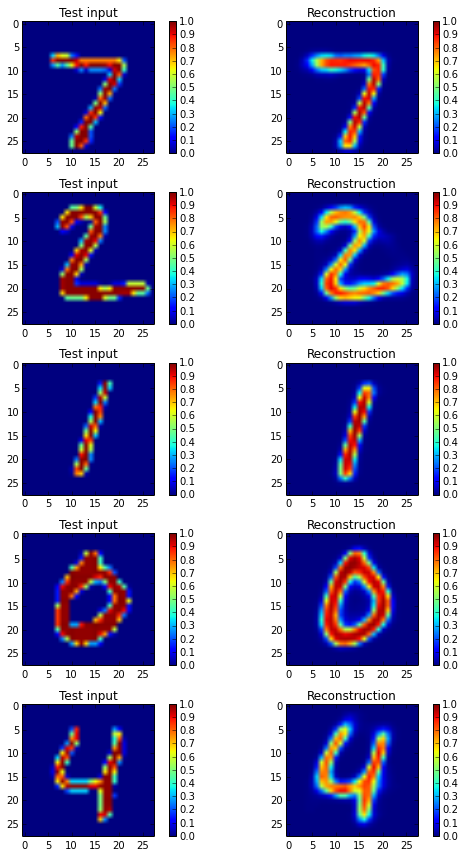

In [12]:
x_sample = mnist.test.next_batch(100)[0]
print x_sample.shape
x_reconstruct = vae.reconstruct(x_sample)
# x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [83]:
network_architecture = \
    dict(n_input=784) # MNIST data input (img shape: 28*28)
params = \
    dict(summary_folder='./summary/test2d_conv', 
         model_folder='./snapshot/test2d_conv',
         save_name='model_test',
         epoch_test=5,
         reweight=1, 
         batch_size=128, 
         learning_rate=1e-2,
         n_z=2)  # dimensionality of latent space)
vae_2d = VariationalAutoencoder(params, network_architecture)

Tensor("add_39:0", shape=(?, 2), dtype=float32)


TypeError: Expected binary or unicode string, got None

In [20]:
print vae_2d.z_mean

Tensor("Slice_3:0", shape=(200, 2), dtype=float32)


In [13]:
train(vae_2d, params, training_epochs=1, display_step=100)

Epoch: 000 batch: 000 cost= 0.791339018 -- cost_recon=0.788936615, cost_vae=0.002402403
Epoch: 000 batch: 100 cost= 0.388919986 -- cost_recon=0.381453144, cost_vae=0.007466856
Epoch: 000 batch: 200 cost= 0.295664768 -- cost_recon=0.287536563, cost_vae=0.008128209
Epoch: 000 batch: 300 cost= 0.260206923 -- cost_recon=0.252036484, cost_vae=0.008170430
Epoch: 000 batch: 400 cost= 0.247701392 -- cost_recon=0.238516360, cost_vae=0.009185030
--> Model saved to file: ./snapshot/test2d_conv/model_test-epoch0.ckpt


In [6]:
restore(vae_2d, params)

--> Model restored from file: ./snapshot/test2d_conv/model_test-epoch5.ckpt


Tensor("Squeeze_3:0", shape=(), dtype=int32)


<matplotlib.colorbar.Colorbar instance at 0x7f7a317e8f80>

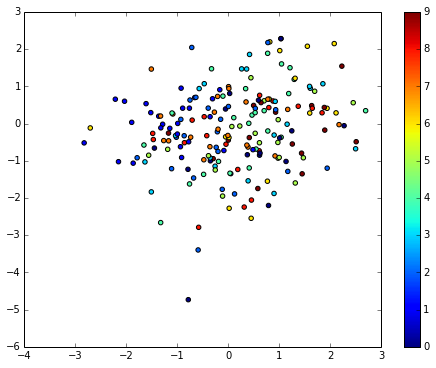

In [25]:
x_sample, y_sample = mnist.test.next_batch(200)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

In [ ]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()

## Summary
In summary, tensorflow is well suited to rapidly implement a prototype of machine learning models like VAE. The resulting code could be easily executed on GPUs as well (requiring just that tensorflow with GPU support was installed). VAE allows learning probabilistic encoders and decoders of data in an end-to-end fashion.

In [ ]:
%load_ext watermark
%watermark -a "Jan Hendrik Metzen" -d -v -m -p numpy,scikit-learn